In [1]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'predictive_analytics/MarketingData.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
marketing_data = pd.read_csv(file_content_stream)
marketing_data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel
0,6623.613537,5513.093240,6019.057354,5669.568008,5898.660607,5179.234947,2
1,5642.542497,5829.866565,3960.339943,4270.020548,3498.818262,4327.423268,2
2,5292.078175,6634.370556,4444.335138,4888.286021,3265.391352,4887.560190,2
3,5595.227928,4754.860698,2977.856511,3462.490957,3609.264559,4268.641413,0
4,5126.693267,6009.649079,3811.569943,4744.115976,3829.516831,5097.491872,2


# EDA

In [2]:
marketing_data['Channel'].value_counts()

0    5007
3    5002
1    5001
2    4990
Name: Channel, dtype: int64

#### Visualization

<AxesSubplot: xlabel='Channel', ylabel='Delicassen'>

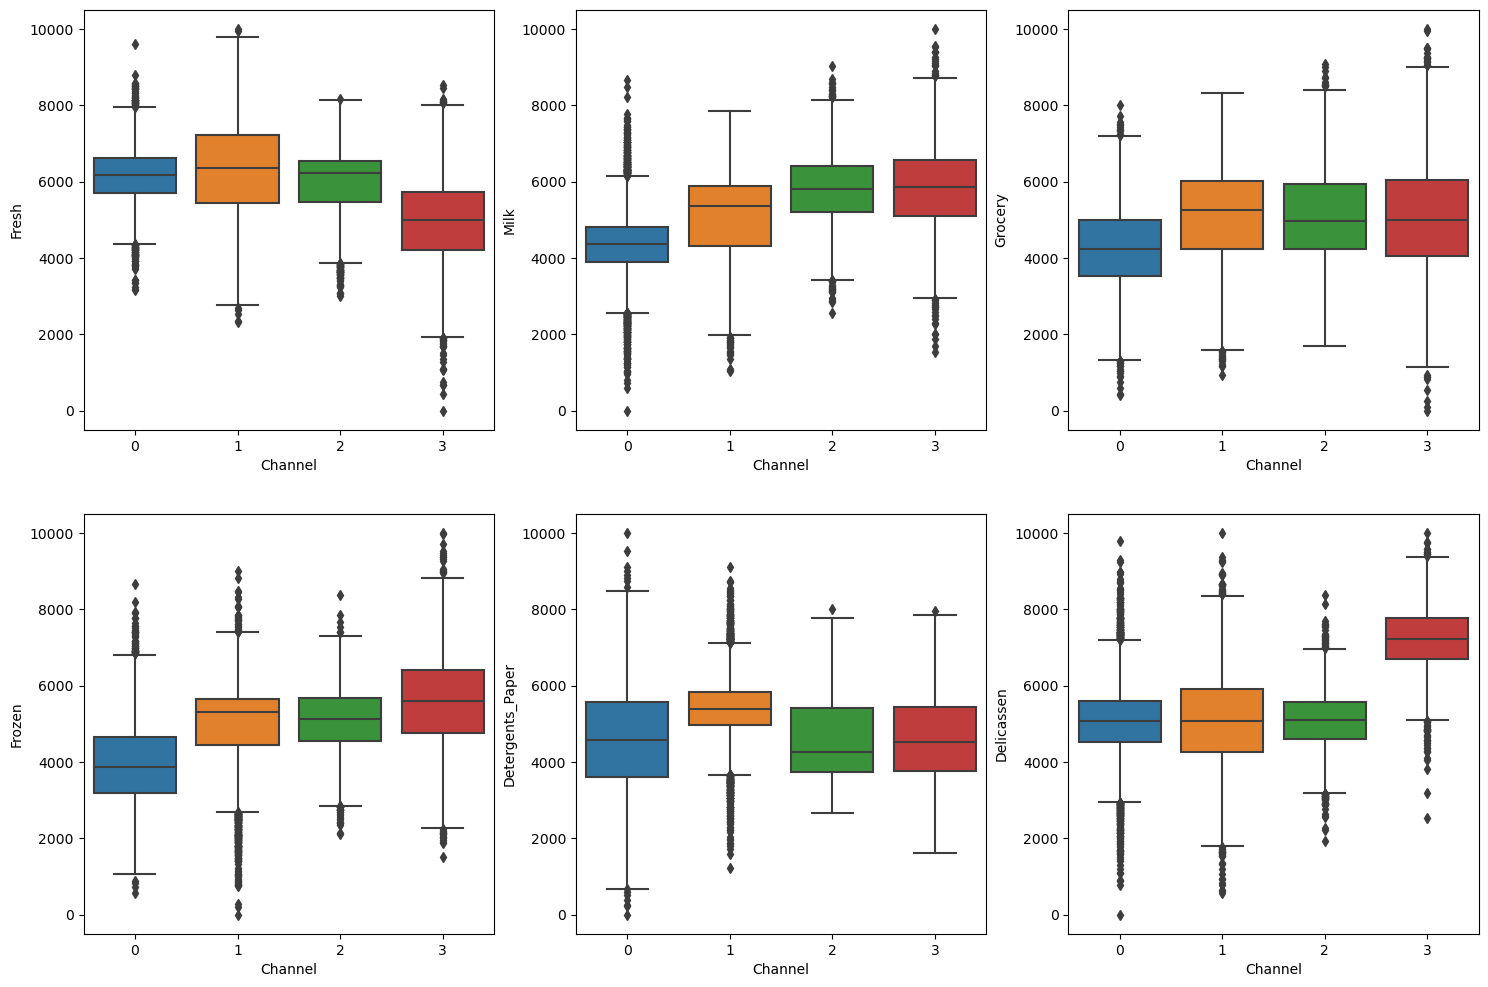

In [3]:
fig, axes = plt.subplots(2, 3, figsize = (18, 12))

sns.boxplot(ax = axes[0,0], x = 'Channel', y = 'Fresh', data = marketing_data)
sns.boxplot(ax = axes[0,1], x = 'Channel', y = 'Milk', data = marketing_data)
sns.boxplot(ax = axes[0,2], x = 'Channel', y = 'Grocery', data = marketing_data)

sns.boxplot(ax = axes[1,0], x = 'Channel', y = 'Frozen', data = marketing_data)
sns.boxplot(ax = axes[1,1], x = 'Channel', y = 'Detergents_Paper', data = marketing_data)
sns.boxplot(ax = axes[1,2], x = 'Channel', y = 'Delicassen', data = marketing_data)

<dl>
    <dt>The above box plots have a few interesting takaways.</dt>
    <dt>Channel 0</dt>
    <dd>Channel 0 typically has a lower value in Frozen, Milk, and Grocery.</dd>
    <dt>Channels 1 and 2</dt>
    <dd>Channels 1 and 2 typically have similar values in many categories. Channel 1 has a slightly lower value in Milk and a slightly higher value in Detergents_Paper</dd>
    <dt>Channel 3</dt>
    <dd>Channel 3 typically has a higher value in Delicassen and Frozen. This channel also typically has a lower value in Fresh</dd>

    
</dl>

In [4]:
X = marketing_data.drop(columns = 'Channel')
Y = marketing_data['Channel']

## Split Data ##
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)

## Scale Data ##
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Random Forest Models
## One vs Rest

In [5]:
## Random Forest Model ##
one_vs_rest_md = OneVsRestClassifier(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 3)).fit(X_train, Y_train)

## Predictions ##
one_vs_rest_pred = one_vs_rest_md.predict_proba(X_test)

## Labels ##
one_vs_rest_pred = np.argmax(one_vs_rest_pred, axis = 1)
print(classification_report(Y_test, one_vs_rest_pred))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1001
           1       0.75      0.61      0.67      1000
           2       0.69      0.83      0.76       998
           3       0.77      0.89      0.82      1001

    accuracy                           0.74      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.74      0.74      4000



## One vs One

In [6]:
## Random Forest Model ##
one_vs_one_md = OneVsOneClassifier(estimator = RandomForestClassifier(n_estimators = 500, max_depth = 3)).fit(X_train, Y_train)

## Predictions ##
one_vs_one_pred = one_vs_one_md.predict(X_test)

## Labels ##
print(classification_report(Y_test, one_vs_one_pred))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1001
           1       0.65      0.74      0.69      1000
           2       0.82      0.70      0.76       998
           3       0.76      0.90      0.83      1001

    accuracy                           0.75      4000
   macro avg       0.76      0.75      0.75      4000
weighted avg       0.76      0.75      0.75      4000



<dl>
    <dt>Summary</dt>
    <dd>The One vs Rest classifier gave a slightly higher recall score for class 2 but preformed the same or slightly worse in most other areas. Because of this, I would use the One vs One classifier to predict the best channel.</dd>
</dl>